# Memory & Threads in Conversational Agentic AI Systems in LangGraph

Every interaction between the user and the agentic system is in isolation and a new request without keep track of past historical conversations (by default). By leveraging memory and threads we can make our agentic system conversational.

![](https://i.imgur.com/nJn1o09.png)

#### Memory in LangGraph:

- Utilizes a built-in persistence layer to maintain graph state across executions.
- Enables features like human-in-the-loop interactions, time travel, fault tolerance and conversational capabilities

#### Threads:

- Serve as unique identifiers for sequences of checkpoints (agent state snapshots).
- Allow retrieval and management of graph states post-execution.
- Specified during graph invocation via {"configurable": {"thread_id": "user-session-id"}}.
- User session id can be generated and assigned per unique user or user session
- This is used by the agent to refer to past conversation and agent state history for any user session at any time
- Enables multi-user conversation for your agent


In [1]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64
!pip install langgraph-checkpoint-sqlite==2.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.1
    Uninstalling langsmith-0.3.1:
      Successfully uninstalled langsmith-0.3.1
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.15
    Uninstalling langchain-0.3.15:
      Successfully uninstalled langchain-0.3.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.4 MB/s eta 0:00:00


## Enter Open AI API Key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Setup Environment Variables

In [4]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Augment the LLM with tools

Here we define our custom search tool and then bind it to the LLM to augment the LLM

In [6]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool

llm = ChatOpenAI(model="gpt-4o", temperature=0)

tavily_search = TavilySearchAPIWrapper()
@tool
def search_web(query: str, num_results=5):
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=num_results,
                                        search_depth='advanced',
                                        include_raw_content=True)
    return results

tools = [search_web]
llm_with_tools = llm.bind_tools(tools=tools)

## Build Agentic Graph with In-Memory Persistence

In [7]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


# Augmented LLM with Tools Node function
def tool_calling_llm(state: State) -> State:
    current_state = state["messages"]
    return {"messages": [llm_with_tools.invoke(current_state)]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools=tools))
builder.add_edge(START, "tool_calling_llm")

# Conditional Edge
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from LLM is a tool call -> tools_condition routes to tools
    # If the latest message (result) from LLM is a not a tool call -> tools_condition routes to END
    tools_condition,
    ["tools", END]
)
builder.add_edge("tools", "tool_calling_llm") # this is the key feedback loop
builder.add_edge("tools", END)

# add in-memory persistence (transient memory)
memory = MemorySaver()
agent_inmem = builder.compile(checkpointer=memory)

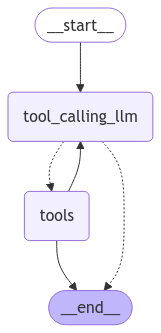

In [8]:
agent_inmem

## Test Agent with In-Memory Persistence

In [9]:
uid = 'user001'
config = {"configurable": {"thread_id": uid}}

In [10]:
user_input = "Explain AI in 1 line"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Explain AI in 1 line
================================== Ai Message ==================================

AI, or Artificial Intelligence, is the simulation of human intelligence processes by machines, especially computer systems, to perform tasks such as learning, reasoning, and problem-solving.


In [11]:
user_input = "Do the same for ML"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Do the same for ML
================================== Ai Message ==================================

Machine Learning (ML) is a subset of AI that enables systems to learn and improve from experience without being explicitly programmed, using algorithms to identify patterns in data.


In [12]:
agent_inmem.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Explain AI in 1 line', additional_kwargs={}, response_metadata={}, id='eef7525c-b9ce-45ba-a72c-c85d895cbbf4'), AIMessage(content='AI, or Artificial Intelligence, is the simulation of human intelligence processes by machines, especially computer systems, to perform tasks such as learning, reasoning, and problem-solving.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 71, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-383391e2-250d-4107-b708-58c272120d99-0', usage_metadata={'input_tokens': 71, 'output_tokens': 35, 'total_tokens': 106, 'input_token_details': {'audio

In [13]:
history = list(agent_inmem.get_state_history(config))
history

[StateSnapshot(values={'messages': [HumanMessage(content='Explain AI in 1 line', additional_kwargs={}, response_metadata={}, id='eef7525c-b9ce-45ba-a72c-c85d895cbbf4'), AIMessage(content='AI, or Artificial Intelligence, is the simulation of human intelligence processes by machines, especially computer systems, to perform tasks such as learning, reasoning, and problem-solving.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 71, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-383391e2-250d-4107-b708-58c272120d99-0', usage_metadata={'input_tokens': 71, 'output_tokens': 35, 'total_tokens': 106, 'input_token_details': {'audi

In [14]:
uid = 'user002'
config = {"configurable": {"thread_id": uid}}

In [15]:
user_input = "Tell me 3 latest OpenAI product releases"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Tell me 3 latest OpenAI product releases
================================== Ai Message ==================================
Tool Calls:
  search_web (call_H9i6SzX1euMvoXCHKYmYdzB0)
 Call ID: call_H9i6SzX1euMvoXCHKYmYdzB0
  Args:
    query: latest OpenAI product releases
    num_results: 3
================================= Tool Message =================================
Name: search_web

{"query": "latest OpenAI product releases", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "All of OpenAI's Releases for Its 12 Days of 'Shipmas' - Business Insider", "url": "https://www.businessinsider.com/everything-openai-released-12-days-of-shipmas-sora-o1-2024-12?op=1", "content": "Everything OpenAI Has Released so Far for 12 Days of 'Shipmas' Campaign - Business Insider Here are all the things OpenAI has released so far for its 12 days of 'Shipmas' campaign OpenAI CEO Sam Altman and mem

In [16]:
user_input = "do the same for Meta releases"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

do the same for Meta releases
================================== Ai Message ==================================
Tool Calls:
  search_web (call_zj6klR2cAOocIr83SnhyVUsN)
 Call ID: call_zj6klR2cAOocIr83SnhyVUsN
  Args:
    query: latest Meta product releases
    num_results: 3
================================= Tool Message =================================
Name: search_web

{"query": "latest Meta product releases", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Latest Meta Company News | Meta - About Facebook", "url": "https://about.fb.com/news/category/technologies/meta/", "content": "Meta Meta Quest 3 Meta Quest 2 Meta Portal Go Ray-Ban Meta smart glasses Meta Quest 3 Meta Quest 2 Ray-Ban Meta smart glasses Meta Quest Meta Quest Learn about Meta Meta Quest Meta Portal Meta Quest Meta Portal Meta Meta Meta Meta Meta Ray-Ban | Meta Glasses Are Getting New AI Features and Mo

In [17]:
uid = 'user001'
config = {"configurable": {"thread_id": uid}}
user_input = "what did we discuss so far"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what did we discuss so far
================================== Ai Message ==================================

We discussed brief one-line explanations of Artificial Intelligence (AI) and Machine Learning (ML). AI was described as the simulation of human intelligence by machines, while ML was defined as a subset of AI that allows systems to learn and improve from experience using data-driven algorithms.


## Build & Test Agentic Graph with On-disk Persistence

In [18]:
# clearing memory database (just for demo, in general should keep it)
!rm memory.db*

rm: cannot remove 'memory.db*': No such file or directory


In [19]:
from langgraph.checkpoint.sqlite import SqliteSaver

def call_conversational_agent(agent_graph, prompt, user_session_id):
    with SqliteSaver.from_conn_string("memory.db") as memory:
        agent_extmem = agent_graph.compile(checkpointer=memory)
        for event in agent_extmem.stream(input={"messages": prompt},
                                         config={"configurable": {"thread_id": user_session_id}},
                                         stream_mode='values'):
            event['messages'][-1].pretty_print()

In [20]:
builder

In [21]:
uid = 'bond007'
prompt = "What is the latest news on Apple? summarize in 3 bullets"
call_conversational_agent(agent_graph=builder,
                          prompt=prompt,
                          user_session_id=uid)

================================ Human Message =================================

What is the latest news on Apple? summarize in 3 bullets
================================== Ai Message ==================================
Tool Calls:
  search_web (call_6O3n4bNH7qNhXIft8R7bPADQ)
 Call ID: call_6O3n4bNH7qNhXIft8R7bPADQ
  Args:
    query: latest news on Apple
    num_results: 3
================================= Tool Message =================================
Name: search_web

{"query": "latest news on Apple", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Newsroom - Apple", "url": "https://www.apple.com/newsroom/", "content": "Building on this satellite infrastructure, Apple recently introduced Roadside Assistance via satellite to connect users to AAA if they have car trouble while outside of cellular and Wi-Fi coverage.2  Other safety capabilities that can provide assistance when it matters most include:\nPress Contacts\nBlair Ranger\nApple\nblair_ranger@a

In [22]:
prompt = "What about microsoft?"
call_conversational_agent(agent_graph=builder,
                          prompt=prompt,
                          user_session_id=uid)

================================ Human Message =================================

What about microsoft?
================================== Ai Message ==================================
Tool Calls:
  search_web (call_yuRvDF3jIsoatQGVHdLhohSx)
 Call ID: call_yuRvDF3jIsoatQGVHdLhohSx
  Args:
    query: latest news on Microsoft
    num_results: 3
================================= Tool Message =================================
Name: search_web

{"query": "latest news on Microsoft", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "The Official Microsoft Blog", "url": "https://blogs.microsoft.com/", "content": "AI transformation and the technology driving change\nNov 7, 2023\n|\nCharlotte Yarkoni - President, Commerce + Ecosystems, Cloud & AI\nStartups to access high-performance Azure infrastructure, accelerating AI breakthroughs\nNov 6, 2023\n|\nDouglas Phillips - CVP, Azure Edge + Platform\nHonoring veterans and recognizing their value and contributions at M